In [65]:
#@title Code: Main

#Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

#Import Libraries
import csv
import ipywidgets as widget
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import os
import seaborn as sns
import sklearn
from google.colab import data_table
from IPython.display import clear_output
from ipywidgets import IntText
from itertools import islice
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics.pairwise import cosine_similarity

#Create Boardgame Class
class Boardgame:
    def __init__(self,gameid,name,rank,rating,categories,themes,mechanics,minplayer,maxplayer,minduration,maxduration,weight):
        self.gameid = gameid
        self.name = name
        self.rank = rank
        self.rating = rating
        self.categories = categories
        self.themes = themes
        self.mechanics = mechanics
        self.minplayer = minplayer
        self.maxplayer = maxplayer
        self.minduration = minduration
        self.maxduration = maxduration
        self.weight = weight

    #display class attributes as strings
    def __str__(self):
        return "%s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s" % (
            self.gameid, self.name, self.rank, self.categories, self.themes, self.mechanics, self.minplayer, self.maxplayer,
            self.minduration, self.maxduration, self.weight) 


#Create the dictionary for subcategories that are connected to their game by the boardgame ID key
def get_subcategory_dict():  
    categoriesDict = {}
    with open('/content/drive/My Drive/BoardGameApp/Data/subcategories.csv') as subcategoriesCSV:
        subcategoryData = csv.reader(subcategoriesCSV)
        subcategoryHeader = next(subcategoryData)
        for row in subcategoryData:
            gameid = int(row[0])
            categoriesList = [] 
            for i, col in enumerate(row):
                #The "Card Game" subcategory will be filtered out
                #The reasoning here is that games in this subcategory 
                #have cards in them, but they are not what would commonly 
                #or traditionally be called a "Card Game".
                if col == "1" and i > 0 and subcategoryHeader[i] != "Card Game":
                    categoriesList.append(subcategoryHeader[i])

            categoriesDict[gameid] = categoriesList
    return categoriesDict


#Create the dictionary for themes that are connected to their game by the boardgame ID key  
def get_themes_dict():
    themesDict = {}
    with open('/content/drive/My Drive/BoardGameApp/Data/themes.csv') as themesCSV:
        themesData = csv.reader(themesCSV)
        themesHeader = next(themesData)
        for row in themesData:
            gameid = int(row[0])
            themesList = []
            for i, col in enumerate(row):
                if col == "1" and i > 0:
                    #Some of the themes in the data set have a prefix that needs to be removed
                    if "Theme_" in themesHeader[i]:
                        themesList.append(themesHeader[i][6:])
                    else:
                        themesList.append(themesHeader[i])
            themesList.sort()
            themesDict[gameid] = themesList
    return themesDict


#Create the dictionary for mechanics that are connected to their game by the boardgame ID key
def get_mechanics_dict():
    mechanicsDict = {}
    with open('/content/drive/My Drive/BoardGameApp/Data/mechanics.csv') as mechanicsCSV:
        mechanicsData = csv.reader(mechanicsCSV)
        mechanicsHeader = next(mechanicsData)
        for row in mechanicsData:
            gameid = int(row[0])
            mechanicsList = []
            for i, col in enumerate(row):
                if col == "1" and i > 0:
                    mechanicsList.append(mechanicsHeader[i])
            mechanicsList.sort()
            mechanicsDict[gameid] = mechanicsList

    return mechanicsDict

#This is for creating the boardgame dictionary
def getGameData(gameDict):
    #Load Data
    with open('/content/drive/My Drive/BoardGameApp/Data/games.csv', encoding='utf-8') as gamesCSV:
        gamesData = csv.reader(gamesCSV)
        #Start on the second line since we don't need the header
        gamesHeader = next(gamesData)

        #Get mechanics dictionary
        mechanicsDic = get_mechanics_dict()

        #get subcategories dictionary
        categoriesDic = get_subcategory_dict()

        #Get themes dictionary
        themesDic = get_themes_dict()

        gameDict = {}
        for i, game in enumerate(gamesData):
            #This statement is here because many games are duplicated in the dataset with this rank value
            #It appears this value is used as some sort of place holder, but its not clear
            #My solution to this problem is to just filter it out
            if int(game[31]) != 21926:
                gameid = int(game[0])
                name = game[1]
                rank = int(game[31])
                rating = round(float(game[5]), 2)
                minplayer = int(game[8])
                maxplayer = int(game[9])
                minduration = int(game[19])
                maxduration = int(game[20])
                weight = round(float(game[4]), 2)

                mechanics = mechanicsDic.get(gameid, [])
                categories = categoriesDic.get(gameid, [])
                themes = themesDic.get(gameid, [])

                #This is here since some of the category data, the 'primary categories', are in the games.csv file
                #Above, the category list only contains entries from subcategories.csv
                #This application makes no distinction between 'category' and 'subcategory'
                if int(game[40]) == 1:
                    categories.append("Thematic")
                if int(game[41]) == 1:
                    categories.append("Strategy")
                if int(game[42]) == 1:
                    categories.append("War")
                if int(game[43]) == 1:
                    categories.append("Family")
                #This line appears different because "Card Game" is both a
                #primary and sub category. It is necessary if both forms of this
                #category are used by the app to prevent duplicates. 
                #The current build only includes the primary Card Game 
                #attribute, making this line unneeded, however, it doesn't 
                #break anything, so I'm leaving it in 
                #just incase the card game subcategory is re-incorporated  
                if int(game[44]) == 1 and "Card Game" not in categories:
                    categories.append("Card Game")
                if int(game[45]) == 1:
                    categories.append("Abstract")
                if int(game[46]) == 1:
                    categories.append("Party")
                if int(game[47]) == 1:
                    categories.append("Childrens")
                categories.sort()

                #Create the boardgame object
                boardgame = Boardgame(gameid, name, rank, rating, categories, themes, mechanics, minplayer, maxplayer, minduration, maxduration, weight)

                #Add it to the dictionary
                gameDict.update({i: boardgame})

        #filter out duplicate games with the same name
        #this removes 392 games from the default data set
        filteredGameDict = {}
        for key, boardgame in gameDict.items():
            filteredGameDict.setdefault(boardgame.name, boardgame)
        
        return filteredGameDict

#This method returns a dictionary of attributes and how many times they occur
#in ALL games, or in the TOP n games
#attributeType can be "c", "t", or "m" for Category, Theme, Mehcanic
#top_v_tot can be "top" for top n games, or anything else, such as "total" for all games
#all_v_percentage can be set to "a" for all, or "p" for percentage
def getAttributeTotal(attributeList, attributeType, top_v_tot, all_v_percentage, topNGames): 
    attributeCountDict = {}
    #Grab all attributes and set their count to 0
    for attribute in attributeList:
        attributeCountDict[attribute] = 0   

    #For each game in the complete list of games
    for game in gameDict.values():
        #If we're only looking for the top games and the games are above that rank, skip the game
        if top_v_tot == "top" and game.rank > int(topNGames):
            continue          
        #determine which attribute is being counted: category, theme, or mechanic
        gameAttributeList = []
        if attributeType == "c":
            gameAttributeList = game.categories
        elif attributeType == "t":
            gameAttributeList = game.themes
        elif attributeType == "m":
            gameAttributeList = game.mechanics

        #Get either an all count, or a percentage count (games with two
        #categories, for example, will have each category count as .5 of a games 
        #of that category so that the total game count is not inflacted)  
        for attribute in gameAttributeList:  
            if all_v_percentage == "a":
                attributeCountDict[attribute] += 1
            elif all_v_percentage == "p":
                #a fraction of an instance is added when games have multiple attributes
                attributeCountDict[attribute] += 1 / len(gameAttributeList)

    attributeCountDict = dict(sorted(attributeCountDict.items()))
    return attributeCountDict    

#This is used in the pie charts to collect the smallest entries into an "other" category
#the threshold for qualifying in this category is dynamic and adjusts with the input
def combineSmallEntries(catTopPercentages):
    newCatTopPercentages = {}
    otherPercentage = 0
    totalPercentage = 0.0

    for percentage in catTopPercentages.values():
        totalPercentage += percentage

    for category, percentage in catTopPercentages.items():
        if (percentage / totalPercentage) >= 0.01:
            newCatTopPercentages[category] = percentage
        else:
            otherPercentage += percentage
    for category, percentage in newCatTopPercentages.items():
        if percentage <= 0:
            del newCatTopPercentages[category]
            otherPercentage += percentage

    newCatTopPercentages["Other"] = otherPercentage

    return newCatTopPercentages

#This is the main filtering algorithm for filtering games by attributes
#In the section 2 selection process
def filterGames(gameDict, categories, themes, mechanics, minplayer, maxplayer, lowDuration, upperDuration, lowWeight, highWeight):
    filteredList = []

    #this handles the various strings and turns them into workable ints
    if maxplayer == "13+":
        maxplayer = 13
    if lowDuration == "No Selection":
        lowDuration = 0
    if upperDuration == "No Selection":
        upperDuration = 99999
    if upperDuration == "241+":
        upperDuration = 241       
    if highWeight == "No Selection":
        highWeight = 5
    if lowWeight == "No Selection":
        lowWeight = 0

    for gameid, game in gameDict.items():
        #if the categories is left blank, or if all selected categories are found within a game entry
        if categories == [] or set(categories).issubset(game.categories):
            #if the themes is left blank, or if all selected themes are found within a game entry
            if themes == [] or set(themes).issubset(game.themes):
                #if the mechanics is left blank, or if all selected mechanics are found within a game entry
                if mechanics == [] or set(mechanics).issubset(game.mechanics):
                    #if game in duration range
                    if upperDuration >= game.maxduration and lowDuration <= game.minduration:  
                        #if weight in range
                        if highWeight >= game.weight and highWeight >= lowWeight:
                            #if weight in range
                            if lowWeight <= game.weight:
                                #If the game is in the player range, also look
                                #for "No Selection" and handle appropriately
                                if maxplayer == "No Selection" and minplayer == "No Selection":
                                    filteredList.append(game)
                                elif maxplayer == "No Selection":
                                    if minplayer == game.minplayer:
                                        filteredList.append(game)                        
                                elif minplayer == "No Selection":
                                    if maxplayer == game.maxplayer:
                                        filteredList.append(game)
                                elif minplayer == game.minplayer == game.maxplayer == maxplayer:
                                    filteredList.append(game)
                                elif maxplayer == game.maxplayer and minplayer == game.minplayer:
                                    filteredList.append(game)
    return filteredList 

#This creates a dictionary of the unselected mechanics
#and the number of times they appear in in the filtereed game list
#This will be used to provide the user a list of the 10 most unselected 
#mechanics used by the games in the filtered list
#it could also be used to identify mechanics not used by any game 
#in the filtered list
def get_unselected_mechanics(game_list, selectedMechanics):
    filteredMechanicDict = {}
    for mechanic in mechanicsList:
        filteredMechanicDict[mechanic] = 0 
    for game in game_list:
        for mechanic in game.mechanics:
            if mechanic not in selectedMechanics:
                if mechanic in filteredMechanicDict:
                    filteredMechanicDict[mechanic] += 1
    return filteredMechanicDict

#Submit Button Handler
#This does a ton of stuff
def submitFilterButtonHandler(submitButton):
    
    #Get the dropdown box selections
    selectedCategories = []
    for i in range(3):
        if categoryBoxes[i].value != "No Selection":
            #the -1 is due to adding the "no selection" option
            selectedCategories.append(categoriesList[categoryBoxes[i].index -1])
            
    selectedThemes = []
    for i in range(5):
        if themesBoxes[i].value != "No Selection":
            #the -1 is due to adding the "no selection" option
            selectedThemes.append(themesList[themesBoxes[i].index -1])

    selectedMechanics = []
    for i in range(10):
        if mechanicsBoxes[i].value != "No Selection":
            #the -1 is due to adding the "no selection" option
            selectedMechanics.append(mechanicsList[mechanicsBoxes[i].index -1])

    selectedMaxPlayers = playerCountMaxBox.value
    selectedMinPlayers = playerCountMinBox.value
    lowDuration = durationMinBox.value
    upperDuration = durationMaxBox.value
    lowerWeight = low_weightBox.value
    higherWeight = high_weightBox.value

    #Get the list of games that meet the filter
    filteredGames = filterGames(gameDict, selectedCategories, selectedThemes, selectedMechanics, selectedMinPlayers, selectedMaxPlayers, lowDuration, upperDuration, lowerWeight, higherWeight)

    #make a rating prediction based on the selections
    rating_prediction = predict_rating(selectedCategories, selectedThemes, selectedMechanics, selectedMinPlayers, selectedMaxPlayers, lowDuration, upperDuration, lowerWeight, higherWeight)

    #Make a weight predictions based on the selections
    weight_prediction = predict_weight(selectedCategories, selectedThemes, selectedMechanics, selectedMinPlayers, selectedMaxPlayers, lowDuration, upperDuration) 

    #This is for displaying "No Selection" in the filter criteria instead of an empty list
    if selectedCategories == []:
        categories_str = "No Selection"
    else:
        categories_str = str(selectedCategories)
    if selectedThemes == []:
        themes_str = "No Selection"
    else:
        themes_str = str(selectedThemes)
    if selectedMechanics == []:
        mechanics_str = "No Selection"
    else:
        mechanics_str = str(selectedMechanics)

    #clear previous output
    clear_output()

    #display the button and filter selections
    display(submitButton)
    print("Filter Criteria:")
    print("-----------------------------------------------------")
    print("Categories: " + categories_str)
    print("Themes: " + themes_str)
    print("Mechanics: " + mechanics_str)
    print("Min Players: " + str(selectedMinPlayers))
    print("Max Players: " + str(selectedMaxPlayers))
    print("Lower Duration: " + str(lowDuration))
    print("Upper Duration: " + str(upperDuration))
    print("Complexity Lower Threshold: " + str(lowerWeight))
    print("Complexity Upper Threshold: " + str(higherWeight))
    print("-----------------------------------------------------")
    
    #display the resulting game count, and the predictions
    print("Results: " + str(len(filteredGames)) + " games have the selected attributes\n")

    print("Predicted Rating: " + str(rating_prediction))
    print("Predicted complexity rating (weight): " + str(weight_prediction) + "\n")

    #if there are no results
    if filteredGames == []:  
        #get a list of similar games instead
        filteredGames = get_similar_games(selectedCategories, selectedThemes, selectedMechanics, n=25, similarity_threshold=0.5)
        
        #if there are no similar games
        if filteredGames == []:
            print("No existing games fully meet this criteria and there are no games considered similar. For data visualization, try adding additional or selecting different attributes.")
        #If there are similar games
        else:
            #Create the Standard Ranked Deviation data
            sortedRankList = sorted(filteredGames, key=lambda x: x.rank)
            rankList = [game.rank for game in sortedRankList]
            rank_deviationData = np.array(rankList)
            rank_mean = np.mean(rank_deviationData)
            rank_median = np.median(rank_deviationData)
            standardDeviation = np.std(rank_deviationData)

            #CReate the standard rating deviation data
            sortedGames = sorted(filteredGames, key=lambda x: x.rating)
            ratingList = [game.rating for game in sortedGames]
            rating_deviationData = np.array(ratingList)
            rating_mean = np.mean(rating_deviationData)
            rating_median = np.median(rating_deviationData)
            
            #Print the average and median for both rating and rank
            print("Average Rating: " + str(round(rating_mean, 2)))
            print("Median Rating: " + str(round(rating_median, 2)) + "\n")
    
            print("Average Rank: " + str(int(round(rank_mean, 0))))
            print("Median Rank: " + str(int(round(rank_median, 0))) + "\n")

            #Explain what games are being used for the data
            print("No existing games fully meet this criteria. Below are data visualizations for games that are the most similar to the categories, themes, and mechanics selected.\n") 
            
            #create first figure, a single rowed table containing charts in each column
            fig, (ax_d, ax_rating) = plt.subplots(1, 2, figsize = (25, 10))

            #Create the standard rank deviation chart
            x = np.arange(len(rank_deviationData))
            ax_d.errorbar(x, rank_deviationData, yerr = 0, fmt="o")
            ax_d.axhline(rank_mean, color='r', linestyle='--')
            ax_d.axhline(rank_median, color='y', linestyle='--')
            ax_d.axhline(int(topNGames), color='g', linestyle='--')
            ax_d.set_ylim(bottom=0)
            ax_d.set_xlabel("Game Sorted by Rank")
            ax_d.set_ylabel("Rank")
            ax_d.set_title("Standard Ranking Deviation")
            ax_d.text(.05, .8, "Green: Top " + str(topNGames) + "\nYellow: Median\nRed: Mean", ha='left', va='center', transform=ax_d.transAxes, fontsize=16)
            for font in ([ax_d.title, ax_d.xaxis.label, ax_d.yaxis.label] + ax_d.get_xticklabels() + ax_d.get_yticklabels()):
                font.set_fontsize(16)

            #Create the standard rating deviation chart
            y = np.arange(len(rating_deviationData))
            ax_rating.errorbar(y, rating_deviationData, yerr = 0, fmt="o")
            ax_rating.axhline(rating_mean, color='r', linestyle='--')
            ax_rating.axhline(rating_median, color='y', linestyle='--')
            ax_rating.set_ylim(bottom=0)
            ax_rating.set_xlabel("Game Sorted by Rating")
            ax_rating.set_ylabel("Rating")
            ax_rating.set_title("Standard Rating Deviation")
            ax_rating.text(.05, .3, "Yellow: Median\nRed: Mean", ha='left', va='center', transform=ax_rating.transAxes, fontsize=16)
            for font in ([ax_rating.title, ax_rating.xaxis.label, ax_rating.yaxis.label] + ax_rating.get_xticklabels() + ax_rating.get_yticklabels()):
                font.set_fontsize(16)

            #display the first figure with the two charts inside
            plt.subplots_adjust(wspace=.2)
            plt.show()        
            #spacing
            print("\n")

            #create second figure, a single rowed table containing charts in each column
            fig, (ax_m, ax_h) = plt.subplots(1, 2, figsize = (25, 10))

            # Determine the length of the longest list
            max_len = max(len(selectedCategories), len(selectedThemes), len(selectedMechanics), len(rating_list))

            #Create lists just for the heat map
            heatcategoriesList = selectedCategories
            heatthemesList = selectedThemes
            heatmechanicsList = selectedMechanics

            #Pad the heat map lists since they must all be the same length
            heatcategoriesList += [""] * (max_len - len(selectedCategories))
            heatthemesList += [""] * (max_len - len(selectedThemes))
            heatmechanicsList += [""] * (max_len - len(selectedMechanics))
            rating_list += [""] * (max_len - len(rating_list))

            #Create the data frame
            df = pd.DataFrame({'Categories': heatcategoriesList, 'Themes': heatthemesList, 'Mechanics': heatmechanicsList, 'Rating': rating_list})     
            #Put the data frame on a pivot table
            pivot = pd.pivot_table(df, values='Rating', index=['Categories', 'Themes'], columns=['Mechanics'])
            #display the pivot table as a heatmap
            sns.heatmap(pivot, cmap='coolwarm', ax=ax_h)
            #set the title and axis labels
            ax_h.set_title('Categories, Themes, and Mechanics in Relation to Game Rating')
            ax_h.set_xlabel('Mechanics')
            ax_h.set_ylabel('Categories & Themes')           
            #set the font
            for font in ([ax_h.title, ax_h.xaxis.label, ax_h.yaxis.label] + ax_h.get_xticklabels() + ax_h.get_yticklabels()):
                font.set_fontsize(12)

            #Get the unused mechanics
            filteredMechanicDict = get_unselected_mechanics(filteredGames, selectedMechanics)
            #Sort the dictionary by value in descending order
            filteredMechanicDict = sorted(filteredMechanicDict.items(), key=lambda x: x[1], reverse=True)
            #Get the top 15 {mechanic:Number of Appearances}
            filteredMechanicDict = dict(filteredMechanicDict[:15])
              
            #This chart is for the appearances of categories in the top games
            ax_m.barh(list(filteredMechanicDict.keys()), list(filteredMechanicDict.values()))
            ax_m.invert_yaxis()
            ax_m.set_title("15 Additional Mechanics Most Used in Games of this Type")
            for font in ([ax_m.title, ax_m.xaxis.label, ax_m.yaxis.label] + ax_m.get_xticklabels() + ax_m.get_yticklabels()):
                font.set_fontsize(16)

            #display the figure with the two charts inside
            plt.subplots_adjust(wspace=.2)

            # display the plot
            plt.show()

            #Create and display the similar games table
            #sorted in most similar to least simlar
            similar_game_table = get_similar_game_table(selectedCategories, selectedThemes, selectedMechanics)
            print("\nSimilar Games Table")
            display(similar_game_table)
    else:                    
        #get the filtered games and create table data
        tableData = []
        filteredGames.sort(key=lambda game: game.rank)
        for game in filteredGames:
            row = {"Name": game.name, "Rank": game.rank, "Rating": game.rating, 
                  "Complexity": game.weight, "Min Players": game.minplayer, 
                  "Max Players": game.maxplayer, 
                  "Min Duration": game.minduration, 
                  "Max Duration": game.maxduration, 
                  "Categories": game.categories, "Themes": game.themes, 
                  "Mechanics": game.mechanics}
            tableData.append(row)     
        filteredGameTable = pd.DataFrame(tableData)
        filteredGameTable.index += 1
        data_table.enable_dataframe_formatter()

        #Create the Standard Rank Deviation data
        rankList = [game.rank for game in filteredGames]
        rank_deviationData = np.array(rankList)
        rank_mean = np.mean(rank_deviationData)
        rank_median = np.median(rank_deviationData)
        standardDeviation = np.std(rank_deviationData)
        
        #Create the Standard Rating Deviation data
        sortedGames = sorted(filteredGames, key=lambda x: x.rating)
        ratingList = [game.rating for game in sortedGames]
        rating_deviationData = np.array(ratingList)
        rating_mean = np.mean(rating_deviationData)
        rating_median = np.median(rating_deviationData)
        
        #Print the average and median
        print("Average Rating: " + str(round(rating_mean, 2)))
        print("Median Rating: " + str(round(rating_median, 2)) + "\n")
 
        print("Average Rank: " + str(int(round(rank_mean, 0))))
        print("Median Rank: " + str(int(round(rank_median, 0))) + "\n")

        #create first figure that contains the charts in each column
        fig, (ax_d, ax_rating) = plt.subplots(1, 2, figsize = (25, 10))

        #Create the standard rank deviation chart
        x = np.arange(len(rank_deviationData))
        ax_d.errorbar(x, rank_deviationData, yerr = 0, fmt="o")
        ax_d.axhline(rank_mean, color='r', linestyle='--')
        ax_d.axhline(rank_median, color='y', linestyle='--')
        ax_d.axhline(int(topNGames), color='g', linestyle='--')
        ax_d.set_ylim(bottom=0)
        ax_d.set_xlabel("Game Sorted by Rank")
        ax_d.set_ylabel("Rank")
        ax_d.set_title("Standard Ranking Deviation")
        ax_d.text(.05, .8, "Green: Top " + str(topNGames) + "\nYellow: Median\nRed: Mean", ha='left', va='center', transform=ax_d.transAxes, fontsize=16)
        for font in ([ax_d.title, ax_d.xaxis.label, ax_d.yaxis.label] + ax_d.get_xticklabels() + ax_d.get_yticklabels()):
            font.set_fontsize(16)

        #Create the standard rating deviation chart
        y = np.arange(len(rating_deviationData))
        ax_rating.errorbar(y, rating_deviationData, yerr = 0, fmt="o")
        ax_rating.axhline(rating_mean, color='r', linestyle='--')
        ax_rating.axhline(rating_median, color='y', linestyle='--')
        ax_rating.set_ylim(bottom=0)
        ax_rating.set_xlabel("Game Sorted by Rating")
        ax_rating.set_ylabel("Rating")
        ax_rating.set_title("Standard Rating Deviation")
        ax_rating.text(.05, .3, "Yellow: Median\nRed: Mean", ha='left', va='center', transform=ax_rating.transAxes, fontsize=16)
        for font in ([ax_rating.title, ax_rating.xaxis.label, ax_rating.yaxis.label] + ax_rating.get_xticklabels() + ax_rating.get_yticklabels()):
            font.set_fontsize(16)

        #display first figure with the two charts inside
        plt.subplots_adjust(wspace=.2)
        plt.show()        

        #spacing
        print("\n")

        #Create second figure
        fig, (ax_m, ax_h) = plt.subplots(1, 2, figsize = (25, 10))

        # Determine the length of the longest list
        max_len = max(len(selectedCategories), len(selectedThemes), len(selectedMechanics), len(rating_list))

        #Create special lists just for heatmap
        heatcategoriesList = selectedCategories
        heatthemesList = selectedThemes
        heatmechanicsList = selectedMechanics

        #Pad the lists
        heatcategoriesList += [''] * (max_len - len(selectedCategories))
        heatthemesList += [''] * (max_len - len(selectedThemes))
        heatmechanicsList += [''] * (max_len - len(selectedMechanics))
        rating_list += [None] * (max_len - len(rating_list))

        #Create the data frame
        df = pd.DataFrame({'Categories': heatcategoriesList, 'Themes': heatthemesList, 'Mechanics': heatmechanicsList, 'Rating': rating_list})  
        pivot = pd.pivot_table(df, values='Rating', index=['Categories', 'Themes'], columns=['Mechanics'])

        #pivot table as a heatmap
        sns.heatmap(pivot, cmap='coolwarm', ax=ax_h)

        #set the title and axis labels and font
        ax_h.set_title('Categories, Themes, and Mechanics in Relation to Game Rating')
        ax_h.set_xlabel('Mechanics')
        ax_h.set_ylabel('Categories & Themes')
        for font in ([ax_h.title, ax_h.xaxis.label, ax_h.yaxis.label] + ax_h.get_xticklabels() + ax_h.get_yticklabels()):
            font.set_fontsize(12)

        #get unselected mechanics
        filteredMechanicDict = get_unselected_mechanics(filteredGames, selectedMechanics)
        #Sort the dictionary by value in descending order
        filteredMechanicDict = sorted(filteredMechanicDict.items(), key=lambda x: x[1], reverse=True)
        #Get the top 15 {mechanic:Number of Appearances}
        filteredMechanicDict = dict(filteredMechanicDict[:15])
          
        #make the chart
        ax_m.barh(list(filteredMechanicDict.keys()), list(filteredMechanicDict.values()))
        ax_m.invert_yaxis()
        ax_m.set_title("15 Additional Mechanics Most Used in Games of this Type")
        for font in ([ax_m.title, ax_m.xaxis.label, ax_m.yaxis.label] + ax_m.get_xticklabels() + ax_m.get_yticklabels()):
            font.set_fontsize(16)

        #space the columns/charts
        plt.subplots_adjust(wspace=.2)

        #display the figure with the two charts inside
        plt.show()

        #Display table
        print("\nSimilar Games Table")
        display(filteredGameTable)

def display_category_charts(n):
    #Create the initial input form and button
    catNumBox = widget.IntText(value = n, min = 1, max = 20000)
    catThresholdSubmit = widget.Button(description='Submit')
    display(catNumBox, catThresholdSubmit)

    #This refereshes the entire cell
    def category_chart_submit(button):
        n = catNumBox.value
        #clear the cell
        clear_output()
        display_category_charts(n)
    
    catThresholdSubmit.on_click(category_chart_submit)
    
    #Alert user that a selection was made
    print(f"Top Rank Threshold set to " + str(n))

    #create a single rowed figure that contains the charts in each column
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (25, 10))

    #This chart is for the appearances of categories in the top games
    ax1.barh(list(getAttributeTotal(categoriesList, "c", "top", "a", n).keys()), list(getAttributeTotal(categoriesList, "c", "top", "a", n).values()))
    ax1.invert_yaxis()
    ax1.set_title(("Instances of each Category in the Top " + str(n) + " Games"))

    for font in ([ax1.title, ax1.xaxis.label, ax1.yaxis.label] + ax1.get_xticklabels() + ax1.get_yticklabels()):
        font.set_fontsize(20)

    #This chart is for the total category appearances across all games
    ax2.barh(list(categoryCount.keys()), list(categoryCount.values()))
    ax2.invert_yaxis()
    ax2.set_title("Instances of each Category in All Games")

    for font in ([ax2.title, ax2.xaxis.label, ax2.yaxis.label] + ax2.get_xticklabels() + ax2.get_yticklabels()):
        font.set_fontsize(20)

    plt.subplots_adjust(wspace=0.45)
    plt.show()

    catTopPercentages = getAttributeTotal(categoriesList, "c", "top", "p", n)

    newCatTopPercentages = combineSmallEntries(catTopPercentages)
    newCatTopPercentages = dict(sorted(newCatTopPercentages.items(), key=lambda item: item[1], reverse=True))

    catAllPercentages = getAttributeTotal(categoriesList, "c", "tot", "p", n)
    catAllPercentages = dict(sorted(catAllPercentages.items(), key=lambda item: item[1], reverse=True))

    print("\n")

    #create a single rowed figure that contains the charts in each column
    fig, (ax3, ax4) = plt.subplots(1, 2, figsize = (25, 10))

    #This chart is for the appearances of categories in the top games
    ax3.pie(newCatTopPercentages.values(), labels=newCatTopPercentages.keys(), autopct='%1.1f%%')
    ax3.set_title("Percentage of Top Games Tagged with each Category")

    ax4.pie(catAllPercentages.values(), labels=catAllPercentages.keys(), autopct='%1.1f%%')
    ax4.set_title("Percentage of All Games Tagged with each Category")

    plt.subplots_adjust(wspace=0.0)
    plt.show()

def display_theme_charts(n, k):
    #Create the rank threshold box
    themeNumBox = widget.IntText(value = n, min = 1, max = 20000)
    #Create number of themes threshold box
    themeNumBox2 = widget.IntText(value = k, min = 1, max = 30)
    #Create button
    themeThresholdSubmit = widget.Button(description='Submit')

    #place the initial button and charts
    print("Top Rank Threshold (default 500):")
    display(themeNumBox)
    print("Number of themes to display (default 10):")
    display(themeNumBox2)
    display(themeThresholdSubmit)

    #This refereshes the entire cell
    def theme_chart_submit(button):
        n = themeNumBox.value
        k = themeNumBox2.value
        #clear the cell
        clear_output()
        display_theme_charts(n,k)

    themeThresholdSubmit.on_click(theme_chart_submit)

    #create a single rowed figure that contains the charts in each column
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (26, 8))

    #This chart is for the appearances of themes in the top games
    topThemeDict = getAttributeTotal(themesList, "t", "top", "a", n)
    topThemeDict = dict(sorted(topThemeDict.items(), key=lambda item: item[1], reverse=True)[:k])
    topThemeDict = dict(sorted(topThemeDict.items(), reverse=True))
    ax1.barh(list(topThemeDict.keys()), list(topThemeDict.values()))
    ax1.set_title("Top " + str(k) + " Themes in the Top " +  str(n) + " Games")

    for font in ([ax1.title, ax1.xaxis.label, ax1.yaxis.label] + ax1.get_xticklabels() + ax1.get_yticklabels()):
        font.set_fontsize(20)

    #This chart is for the total theme appearances across all games
    topThemeDict = getAttributeTotal(themesList, "t", "total", "a", n)
    topThemeDict = dict(sorted(topThemeDict.items(), key=lambda item: item[1], reverse=True)[:k])
    topThemeDict = dict(sorted(topThemeDict.items()))
    ax2.barh(list(topThemeDict.keys()), list(topThemeDict.values()))
    ax2.invert_yaxis()
    ax2.set_title("Top " + str(k) + " Themes for All Games")
    for font in ([ax2.title, ax2.xaxis.label, ax2.yaxis.label] + ax2.get_xticklabels() + ax2.get_yticklabels()):
        font.set_fontsize(20)

    plt.subplots_adjust(wspace=0.5)

    plt.show()

def display_mechanics_charts(n, k):
    #Create the rank threshold box
    mechNumBox = widget.IntText(value = n, min = 1, max = 20000)
    #Create number of mechanics threshold box
    mechNumBox2 = widget.IntText(value = k, min = 1, max = 30)
    #Create button
    mechThresholdSubmit = widget.Button(description='Submit')

    #create the form and submission button
    print("Top Rank Threshold (default 500):")
    display(mechNumBox)
    print("Number of mechanics to display (default 20):")
    display(mechNumBox2)
    display(mechThresholdSubmit)

    #This refereshes the entire cell
    def mechanic_chart_submit(button):
        n = mechNumBox.value
        k = mechNumBox2.value
        #clear the cell
        clear_output()
        display_theme_charts(n,k)

    mechThresholdSubmit.on_click(mechanic_chart_submit)

    #create a single rowed figure that contains the charts in each column
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (26, 16))

    #This chart is for the appearances of mechanics in the top games
    topMechanicDict = getAttributeTotal(mechanicsList, "m", "top", "a", n)
    topMechanicDict = dict(sorted(topMechanicDict.items(), key=lambda item: item[1], reverse=True)[:k])
    topMechanicDict = dict(sorted(topMechanicDict.items(), reverse=True))
    ax1.barh(list(topMechanicDict.keys()), list(topMechanicDict.values()))
    ax1.set_title("Top " + str(k) + " Mechanics in the Top " +  str(n) + " Games")
    for font in ([ax1.title, ax1.xaxis.label, ax1.yaxis.label] + ax1.get_xticklabels() + ax1.get_yticklabels()):
        font.set_fontsize(20)

    #This chart is for the total mechanic appearances across all games
    topMechanicDict = getAttributeTotal(mechanicsList, "m", "total", "a", n)
    topMechanicDict = dict(sorted(topMechanicDict.items(), key=lambda item: item[1], reverse=True)[:k])
    topMechanicDict = dict(sorted(topMechanicDict.items()))
    ax2.barh(list(topMechanicDict.keys()), list(topMechanicDict.values()))
    ax2.invert_yaxis()
    ax2.set_title("Top " + str(k) + " Mechanics for All Games")
    for font in ([ax2.title, ax2.xaxis.label, ax2.yaxis.label] + ax2.get_xticklabels() + ax2.get_yticklabels()):
        font.set_fontsize(20)

    plt.subplots_adjust(wspace=0.6)

    plt.show()

def display_CTM_options():
    print("Choose up to 3 categories:")
    for i in range(3):
        display(categoryBoxes[i])
    print("The 5 most common categories are:")
    for category in islice(dict(sorted(categoryCount.items(), key=lambda item: item[1], reverse=True)).items(), 5):
        print(category)

    print("\nChoose up to 5 themes:")
    for i in range(5):
        display(themesBoxes[i])
    print("The 5 most common themes are:")
    for theme in islice(dict(sorted(themeCount.items(), key=lambda item: item[1], reverse=True)).items(), 5):
        print(theme) 

    print("\nChoose up to 10 mechanics:")
    for i in range(10):
        display(mechanicsBoxes[i])
    print("The 10 most common mechanics are:")
    for mechanic in islice(dict(sorted(mechanicCount.items(), key=lambda item: item[1], reverse=True)).items(), 10):
        print(mechanic) 

def clear_CTM_handler(clear_button):

    clear_output()

    for i in range(3):
        categoryBoxes[i].value = categoriesListCount[0]
    for i in range(5):
        themesBoxes[i].value = themesListCount[0]
    for i in range(10):
        mechanicsBoxes[i].value = mechanicsListCount[0]

    display(clear_CTM_button)
    display_CTM_options()

def display_PDC_options():
    print("Players")
    display(playerCountMinBox)
    display(playerCountMaxBox)

    print("\nDuration")
    display(durationMinBox)
    display(durationMaxBox)

    print("\nComplexity Rating")
    display(low_weightBox)
    display(high_weightBox)

def clear_PDC_handler(clear_button):

    clear_output()

    playerCountMinBox.value = playerminCountList[0]
    playerCountMaxBox.value = playerCountList[0]
    durationMinBox.value = gameDurationMinList[0]
    durationMaxBox.value = gameDurationMaxList[0]
    low_weightBox.value = gameWeightList[0]
    high_weightBox.value = gameWeightList[0]

    display(clear_PDC_button)
    display_PDC_options()

#This adds the total number of games for each attribute to the string for each attribute
#use for Categories, Themes, and Mechanics
def get_attribute_count(attributeList,attributeCount):
    list_with_count = []
    for attribute in attributeList:
        if attribute in attributeCount:
            list_with_count.append(attribute + " (" + str(attributeCount[attribute]) + ")")    
    return list_with_count

gameDict = getGameData({})
totalGames = len(gameDict)
topNGames = 500

print("Data for " + str(totalGames) + " games has been loaded")

#Create a list of ratings
rating_list = []
for game in gameDict.values():
    rating_list.append(game.rating)

#Get the full list of Categories
categoriesList = []
with open('/content/drive/My Drive/BoardGameApp/Data/subcategories.csv') as categoriesCSV:
    categoriesData = csv.reader(categoriesCSV)
    header = next(categoriesData)
    for row in header[1:]:
        categoriesList.append(row)
    #note that "Card Game" is absent since, despite being a primary category, it is also a subcategory, thus already included
    categoriesList.extend(["Thematic","Strategy","War","Family","Abstract","Party","Childrens"])
#Sort categories list alphabetically          
categoriesList.sort()
#This gets the total number of games for each category 
categoryCount = getAttributeTotal(categoriesList, "c", "total", "a", topNGames)
#get a category list of strings that includes a game tally for each category
categoriesListCount = get_attribute_count(categoriesList, categoryCount)
#Add the no selection option at the start
categoriesListCount.insert(0, "No Selection")
#Create the category selection boxes
categoryBoxes = []
for i in range(3):
    options = widget.Dropdown(options = categoriesListCount)
    categoryBoxes.append(options)

#Get the full list of themes
themesList = []
with open('/content/drive/My Drive/BoardGameApp/Data/themes.csv') as themesCSV:
    themesData = csv.reader(themesCSV)
    header = next(themesData)
    for row in header[1:]:
        if "Theme_" in row:
            themesList.append(row[6:])
        else:
            themesList.append(row)
themesList.sort()
#This gets the total number of games for each theme
themeCount = getAttributeTotal(themesList, "t", "total", "a", topNGames)
#This adds the total number of games for each theme to the string for each theme
themesListCount = get_attribute_count(themesList, themeCount)
themesListCount.insert(0, "No Selection")
#Create the theme boxes
themesBoxes = []
for i in range(5):
    options = widget.Dropdown(options = themesListCount)
    themesBoxes.append(options)

#Get the full list of mechanics
mechanicsList = []
with open('/content/drive/My Drive/BoardGameApp/Data/mechanics.csv') as mechanicsCSV:
    mechanicsData = csv.reader(mechanicsCSV)
    header = next(mechanicsData)
    for row in header[1:]:
        mechanicsList.append(row)    
mechanicsList.sort()
#This gets the total number of games for each mechanic
mechanicCount = getAttributeTotal(mechanicsList, "m", "total", "a", topNGames)
#This adds the total number of games for each mechanic to the string for each mechanic
mechanicsListCount = get_attribute_count(mechanicsList, mechanicCount)
mechanicsListCount.insert(0, "No Selection")
#Create the mechanics boxes
mechanicsBoxes = []
for i in range(10):
    options = widget.Dropdown(options = mechanicsListCount)
    mechanicsBoxes.append(options)

#Create the player count lists
playerminCountList = ["No Selection", 1,2,3,4,5,6,7,8,9,10,11,12]
playerCountList = ["No Selection", 1,2,3,4,5,6,7,8,9,10,11,12,"13+"]
#Create the player count boxes
playerCountMinBox = widget.Dropdown(options = playerminCountList, description = "Lower")
playerCountMaxBox = widget.Dropdown(options = playerCountList, description = "Upper")

#create the duration lists
gameDurationMinList = ["No Selection", 30,60,90,120,150,180,210,240]
gameDurationMaxList = ["No Selection", 30,60,90,120,150,180,210,240,"241+"]
#create the duration boxes
durationMinBox = widget.Dropdown(options = gameDurationMinList, description = "Lower")
durationMaxBox = widget.Dropdown(options = gameDurationMaxList, description = "Upper")

#create the weight list
gameWeightList = ["No Selection", 0, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5,5]
#Create the weight boxes
low_weightBox = widget.Dropdown(options = gameWeightList, description = "Lower")
high_weightBox = widget.Dropdown(options = gameWeightList, description = "Upper")

#Creat the clear selection button for Categories, Themes and Mechanics
clear_CTM_button = widget.Button(description="Clear Selections")
clear_CTM_button.on_click(clear_CTM_handler) 

#Create the clear selection button for Players, Duration, and Weight
clear_PDC_button = widget.Button(description="Clear Selections")
clear_PDC_button.on_click(clear_PDC_handler) 

#Create the submit button to handle the filter selections
submitFilterButton = widget.Button(description="Submit Selections")
submitFilterButton.on_click(submitFilterButtonHandler)    

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Data for 21186 games has been loaded


In [66]:
#@title Code: Rating Prediction - Random Forest

#TUNING#
#This mehtod is used for finding the best learning model parameters
#This takes a long time and it is not recommended to run on a hosted runtime
def tuning(rater_model): 
    #The parameter space to search over
    param_space = {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 5, 10, 20],
        'min_samples_split': [2, 3, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': [0.5, 1.0, 'sqrt']
    }

    random_search = RandomizedSearchCV(estimator=rater_model, param_distributions=param_space, n_iter=50, cv=5, random_state=42)

    return random_search

#Rating predictor Trainer with MLB
def train_rater():
    featuresList = []
    #for each game, get a list of all attributes (the features): categories, themes, mehcanics, min player count, max player count, min duration, max duration, complexity rating
    for game in gameDict.values():
        featuresList.append(game.categories + game.themes + game.mechanics + ["minP " + str(game.minplayer)] + ["maxP " + str(game.maxplayer)] + ["minD " + str(game.minduration)] + ["maxD " + str(game.maxduration)] + ["weight  " + str(game.weight)])

    #Create the binary encoder
    rating_encoder = MultiLabelBinarizer()

    #Encode the features
    features_encoded = rating_encoder.fit_transform(featuresList)

    #Put the ratings in an numpy array
    targets = np.array([game.rating for game in gameDict.values()])

    #Split the data into training and testing sets. 
    #20% for testing and 80% training has yielded the most accurate predictions
    features_train, features_test, targets_train, targets_test = train_test_split(features_encoded, targets,test_size=0.2, random_state=35)

    #Create a RandomForestRegressor model
    rater_model = RandomForestRegressor(n_estimators=200, min_samples_split=4, min_samples_leaf=1, max_features='sqrt', max_depth=None, random_state=35)

    #TUNING#
    ###Use this instead of the above if tuning
    ###rater_model = RandomForestRegressor(random_state=35)
    ###rater_model = tuning(rater_model)

    #Fit the training data
    rater_model.fit(features_train, targets_train)

    #TUNING#
    ###Print the best parameters found if tuning
    ###print('Best parameters found:', rater_model.best_params_)

    #Predict the ratings for the test data
    target_pred = rater_model.predict(features_test)

    #Mean Absolute Percentage Error: difference between predicted and actual ratings
    mape = np.mean(np.abs((targets_test - target_pred) / targets_test)) * 100
    print("Rater MAPE (lower is better): "+ str(mape))

    #Mean Squared Percentage Error: avg squared difference between predicted and actual ratings
    mspe =  np.mean(np.square((targets_test - target_pred) / targets_test)) * 100
    print("Rater MSE (lower is better): " + str(mspe))

    #R Squared: proportion of variation in actual ratings that the model can explain
    r2p = r2_score(targets_test, target_pred) * 100
    print("Rater R2 Score (higher is better): " + str(r2p))

    #Save the model
    file_name = 'BoardgameApp_rater_model.pkl'
    file_path = '/content/drive/My Drive/BoardGameApp/' + file_name
    os.makedirs(os.path.dirname(file_path), exist_ok=True)
    with open(file_path, 'wb') as f:
        pickle.dump(rater_model, f)

    #Save the encoder
    file_name = 'BoardgameApp_rater_encoder.pkl'
    file_path = '/content/drive/My Drive/BoardGameApp/' + file_name
    os.makedirs(os.path.dirname(file_path), exist_ok=True)
    with open(file_path, 'wb') as t:
        pickle.dump(rating_encoder, t)

#train_rater()

def predict_rating(categories, themes, mechanics, minPlayer, maxPlayer, minDuration, maxDuration, minWeight, maxWeight):
    #Get the rating model
    with open('/content/drive/My Drive/BoardGameApp/BoardgameApp_rater_model.pkl', 'rb') as f: 
        rater_model = pickle.load(f)
    #Get the rating encoder
    with open('/content/drive/My Drive/BoardGameApp/BoardgameApp_rater_encoder.pkl', 'rb') as t:
        rating_encoder = pickle.load(t)

    #transform attribute into unique string and handle "No Selection"
    minPlayer = ["minP " + str(minPlayer) if minPlayer != "No Selection" else None]
 
    #transform attribute into unique string and handle "No Selection"
    #Handle maxPlayer at 13+
    if maxPlayer == "13+":
        max_player_list = []
        for game in gameDict.values():
            max_player_list.append(game.maxplayer)
        maxPlayer = []  
        for player_val in max_player_list:
            if player_val >= 13:
                maxDuration.append("maxD " + str(player_val))
    else:
        maxPlayer = ["maxD " + str(maxPlayer)] if maxPlayer != "No Selection" else [None]

    #transform attribute into unique string and handle "No Selection"
    minDuration = ["minD " + str(minDuration) if minDuration != "No Selection" else None]

    #transform attribute into unique string and handle "No Selection"
    #Handle duration at 241+
    if maxDuration == "241+":
        max_duration_list = []
        for game in gameDict.values():
            max_duration_list.append(game.maxduration)
        maxDuration = []  
        for duration in max_duration_list:
            if duration >= 241:
                maxDuration.append("maxD " + str(duration))
    else:
        maxDuration = ["maxD " + str(maxDuration)] if maxDuration != "No Selection" else [None]

    #transform attribute into unique string and handle "No Selection"
    #Get all weights in range
    weight_list = []
    for game in gameDict.values():
        weight_list.append(game.weight)
    featured_weights = []
    for weight in weight_list:
        if minWeight == maxWeight == "No Selection":
            featured_weights = [None]
            break
        elif minWeight == "No Selection":
            if weight <= maxWeight:
                featured_weights.append("weight  " + str(weight))
        elif maxWeight == "No Selection":
            if minWeight <= weight:
                featured_weights.append("weight  " + str(weight))
        elif minWeight <= weight <= maxWeight:
            featured_weights.append("weight  " + str(weight))

    #Build feature list
    features_list = [categories + themes + mechanics + minPlayer + maxPlayer + minDuration + maxDuration + featured_weights]

    # Remove None values from feature_list
    features_filtered = []
    for f_list in features_list:
        for feature in f_list:
            if feature != None:
                features_filtered.append(feature)
    
    features_encoded = rating_encoder.transform([features_filtered])
    
    # Make prediction using trained model
    predicted_rating = rater_model.predict(features_encoded)

    return predicted_rating

#TEST DATA
#categories = ['Strategy', 'Thematic']
#themes = ['Fantasy', 'Economic']
#mechanics = ['Negotiation', 'Area Majority / Influence', 'Auction/Bidding', 'Hand Management', 'Set Collection', 'Action Points']
#minPlayer = 2
#maxPlayer = 4
#minDuration = 90
#maxDuration = "241+"
#minWeight = 4
#maxWeight = 5

#prediction = predict_rating(categories, themes, mechanics, minPlayer, maxPlayer, minDuration, maxDuration, minWeight, maxWeight)
#print("A game with these attributes is predicted to rate: " + str(round(float(prediction), 2)) + "\n")

In [67]:
#@title Code: Weight Prediction - Random Forest

#Weight predictor with MLB
def train_weigher():
    featuresList = []

    for game in gameDict.values():
        if game.weight != 0:
            featuresList.append(game.categories + game.themes + game.mechanics + ["minP " + str(game.minplayer)] + ["maxP " + str(game.maxplayer)] + ["minD " + str(game.minduration)] + ["maxD " + str(game.maxduration)])

    # Create an instance of the OneHotEncoder
    weight_encoder = MultiLabelBinarizer()

    features_encoded = weight_encoder.fit_transform(featuresList)
    
    targets = []
    for game in gameDict.values():
        if game.weight != 0:   
            targets.append(game.weight)

    print("Training on " + str(len(targets)) + " games.")

    # split the data into training and testing sets
    features_train, features_test, targets_train, targets_test = train_test_split(features_encoded, targets, test_size=0.2, random_state=35)
    # create a RandomForestRegressor model and fit the training data
    weight_model = RandomForestRegressor(n_estimators=200, min_samples_split=5, min_samples_leaf=1, max_features='sqrt', max_depth=None, random_state=35)

    weight_model.fit(features_train, targets_train)

    # predict the target ratings for the test data
    target_pred = weight_model.predict(features_test)

    # Mean Absolute Percentage Error: difference between predicted and actual ratings
    mape = np.mean(np.abs((targets_test - target_pred) / targets_test)) * 100
    print("Weigher MAPE (lower is better): "+ str(mape))

    # Mean Squared Percentage Error: avg squared difference between predicted and actual ratings
    mspe =  np.mean(np.square((targets_test - target_pred) / targets_test)) * 100
    print("Weigher MSE (lower is better): " + str(mspe))

    # R Squared: proportion of variation in actual ratings that the model can explain
    r2p = r2_score(targets_test, target_pred) * 100
    print("Weigher R2 Score (higher is better): " + str(r2p))

    #Save the algorithm
    file_name = 'BoardgameApp_weight_model.pkl'
    file_path = '/content/drive/My Drive/BoardGameApp/' + file_name
    os.makedirs(os.path.dirname(file_path), exist_ok=True)
    with open(file_path, 'wb') as f:
        pickle.dump(weight_model, f)

    #Save the encoder
    file_name = 'BoardgameApp_weight_encoder.pkl'
    file_path = '/content/drive/My Drive/BoardGameApp/' + file_name
    os.makedirs(os.path.dirname(file_path), exist_ok=True)
    with open(file_path, 'wb') as f:
        pickle.dump(weight_encoder, f)      

#train_weigher()

def predict_weight(categories, themes, mechanics, minPlayer, maxPlayer, minDuration, maxDuration):
    with open('/content/drive/My Drive/BoardGameApp/BoardgameApp_weight_model.pkl', 'rb') as f:
        weight_model = pickle.load(f)
    with open('/content/drive/My Drive/BoardGameApp/BoardgameApp_weight_encoder.pkl', 'rb') as t:
        weight_encoder = pickle.load(t)

    # create the feature vector for the input game
    features = [] 

    #transform attribute into unique string and handle "No Selection"
    minPlayer = ["minP " + str(minPlayer) if minPlayer != "No Selection" else None]
 
    #transform attribute into unique string and handle "No Selection"
    #Handle maxPlayer at 13+
    if maxPlayer == "13+":
        max_player_list = []
        for game in gameDict.values():
            max_player_list.append(game.maxplayer)
        maxPlayer = []  
        for player_val in max_player_list:
            if player_val >= 13:
                maxDuration.append("maxD " + str(player_val))
    else:
        maxPlayer = ["maxD " + str(maxPlayer)] if maxPlayer != "No Selection" else [None]

    #transform attribute into unique string and handle "No Selection"
    minDuration = ["minD " + str(minDuration) if minDuration != "No Selection" else None]

    #transform attribute into unique string and handle "No Selection"
    #Handle duration at 241+
    if maxDuration == "241+":
        max_duration_list = []
        for game in gameDict.values():
            max_duration_list.append(game.maxduration)
        maxDuration = []  
        for duration in max_duration_list:
            if duration >= 241:
                maxDuration.append("maxD " + str(duration))
    else:
        maxDuration = ["maxD " + str(maxDuration)] if maxDuration != "No Selection" else [None]

    #Build feature list
    features = [categories + themes + mechanics + minPlayer + maxPlayer + minDuration + maxDuration]


    # Remove None values from feature_list
    features_filtered = []
    for f_list in features:
        for feature in f_list:
            if feature != None:
                features_filtered.append(feature)

    features_encoded = weight_encoder.transform([features_filtered])
    
    # Make prediction using trained model
    predicted_weight = weight_model.predict(features_encoded)

    return predicted_weight

#TEST DATA
#categories = ['Strategy', 'Thematic']
#themes = ['Fantasy', 'Economic']
#mechanics = ['Negotiation', 'Area Majority / Influence', 'Auction/Bidding', 'Hand Management', 'Set Collection', 'Action Points']
#minPlayer = 2
#maxPlayer = 4
#minDuration = 90
#maxDuration = "241+"
#minWeight = 4
#maxWeight = 5
#prediction = predict_weight(categories, themes, mechanics, minPlayer, maxPlayer, minDuration, maxDuration)
#print("Predicted Weight: " + str(prediction))

In [68]:
#@title Code: Similarity Prescriber - Cosine Similarity

def get_similar_games(categories, themes, mechanics, n=25, similarity_threshold=0.5):
    
    featuresList = []
    for game in gameDict.values():
        featuresList.append(game.categories + game.themes + game.mechanics)

    #Create the binary encoder
    similarity_encoder = MultiLabelBinarizer()

    #Encode the features
    features_encoded = similarity_encoder.fit_transform(featuresList)
  
    # Preprocess the user's selection
    user_selection = categories + themes + mechanics

    # Encode the user selection
    user_encoded = similarity_encoder.transform([user_selection])

    # Calculate the cosine similarity between the user selection and each game in featuresList
    similarities = cosine_similarity(features_encoded, user_encoded)

    # Sort the list of similar games by decreasing similarity score and return the top n
    top_n_games = []
    for similarity_score, game in sorted(zip(similarities, gameDict.values()), key=lambda x: (x[0], (x[1].categories, x[1].themes, x[1].mechanics)), reverse=True)[:n]:
        if similarity_score > similarity_threshold:
            top_n_games.append(game)

    return top_n_games

def get_similar_game_table(selectedCategories, selectedThemes, selectedMechanics):
    #get the games and create table data
    tableData = []
    similar_games = get_similar_games(selectedCategories, selectedThemes, selectedMechanics)
    #filteredGames.sort(key=lambda game: game.rank)
    for game in similar_games:
        row = {"Name": game.name, "Rank": game.rank, "Rating": game.rating, 
                "Complexity": game.weight, "Min Players": game.minplayer, 
               "Max Players": game.maxplayer, "Min Duration": game.minduration, 
                "Max Duration": game.maxduration, "Categories": game.categories, 
                "Themes": game.themes, "Mechanics": game.mechanics}
        tableData.append(row)   

    similar_game_table = pd.DataFrame(tableData)
    #Start table index at 1
    similar_game_table.index += 1
   
    data_table.enable_dataframe_formatter()
   
    return similar_game_table


# Boardgame Attribute App
This app uses ranked board game data from boardgamegeek.com and has two major sections:

### Section 1 
Used for displaying category, theme, and mechanics data for all ranked games and the top ranking games.

### Section 2
Used for creating hypothetical game with attribute data for categories, themes, mechanics, player counts, game duration, and game complexity rating. The app will predict a rating for the hypothetical game and, if no complexity rating was selected, it will predict the complexity rating.

The hypothetical game's attributes will be compared to games with the same or similar attributes. Data for the following will be available:

1. A standard deviation for game ranking 
2. A standard deviation for game rating
3. a chart of related game mechanics
4. A heat map for category, theme, and mechanic attributes
5. A table for all games that match the filter criteria, or games that are similar with regard to categories, themes, and mechanics. 



# Setion 1

## Category Statistics

The top rank threshold is used to define the range of games considered the most succesful, beginning from rank 1. The suggested value is for the top 500 games. 

Upon submission of a rank threshold, statistics will appear for game categories.

**Note that not all games from the imported dataset have been categorized, and some games feature multiple categories.**


IntText(value=500)

Button(description='Submit', style=ButtonStyle())

Top Rank Threshold set to 500


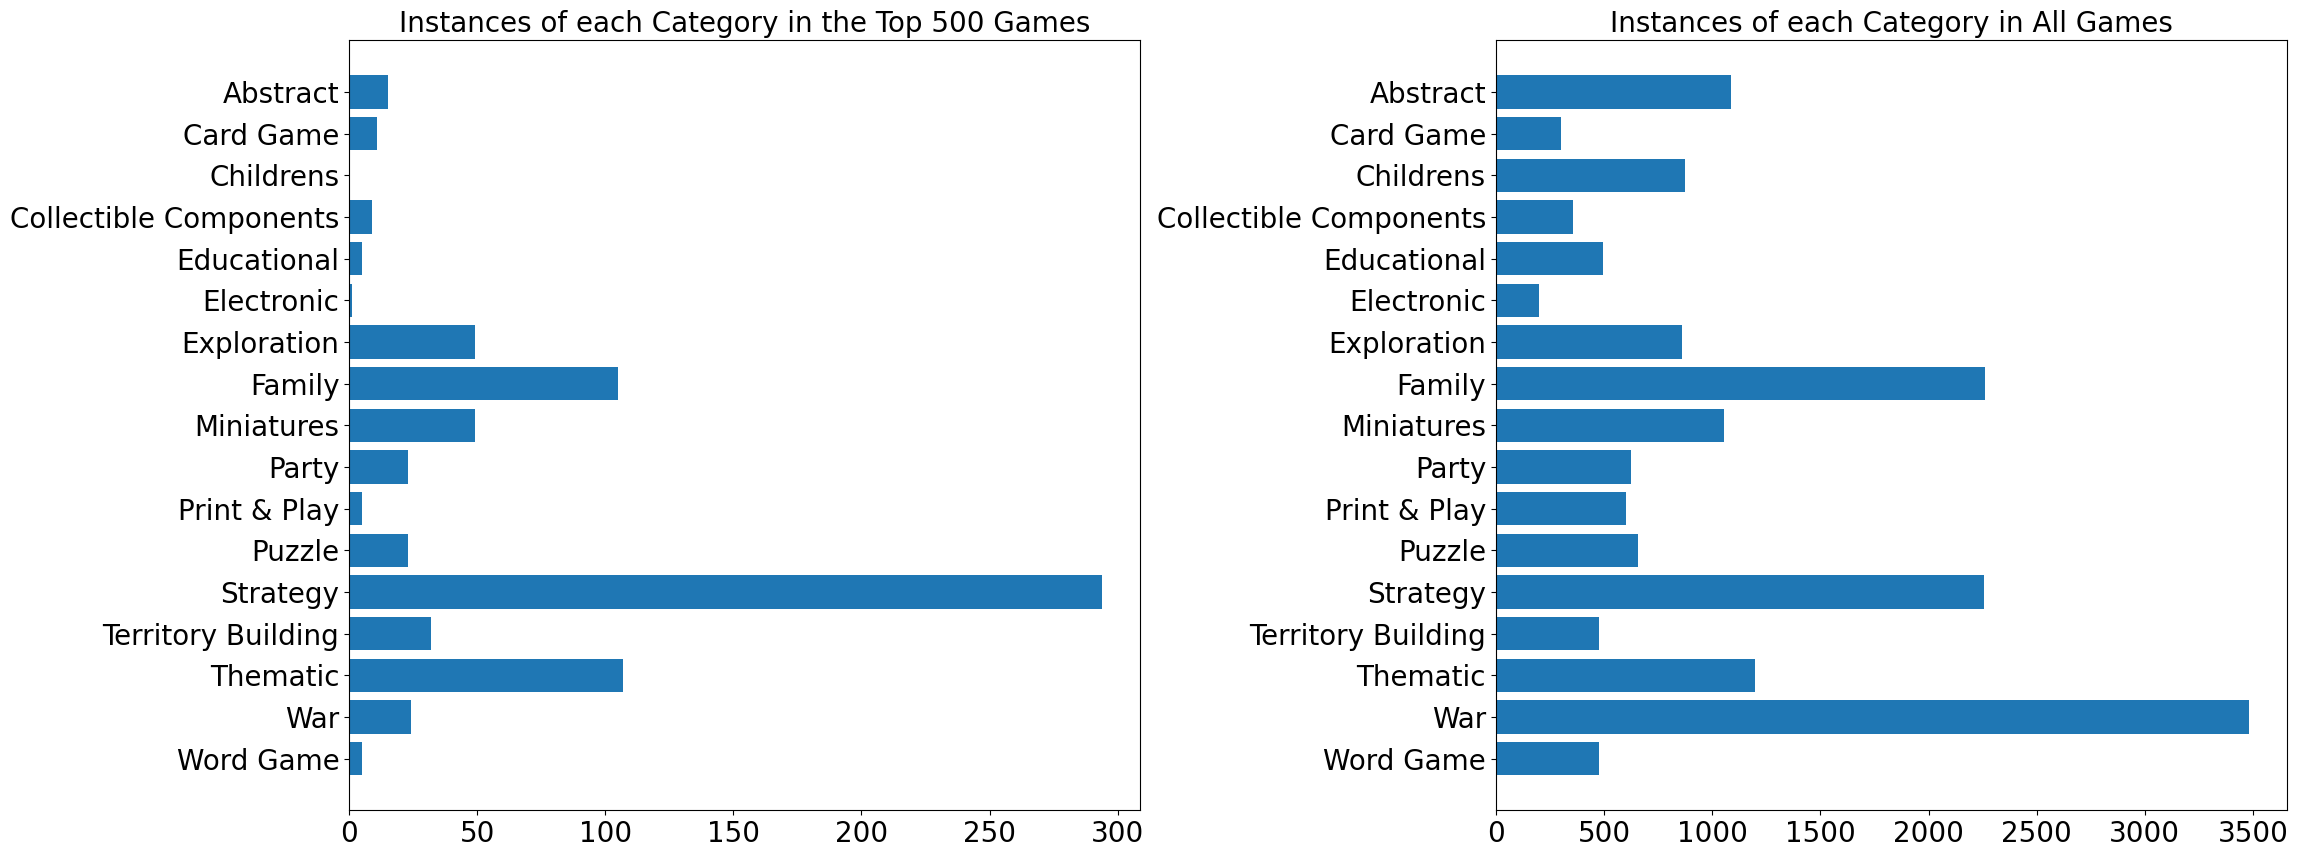

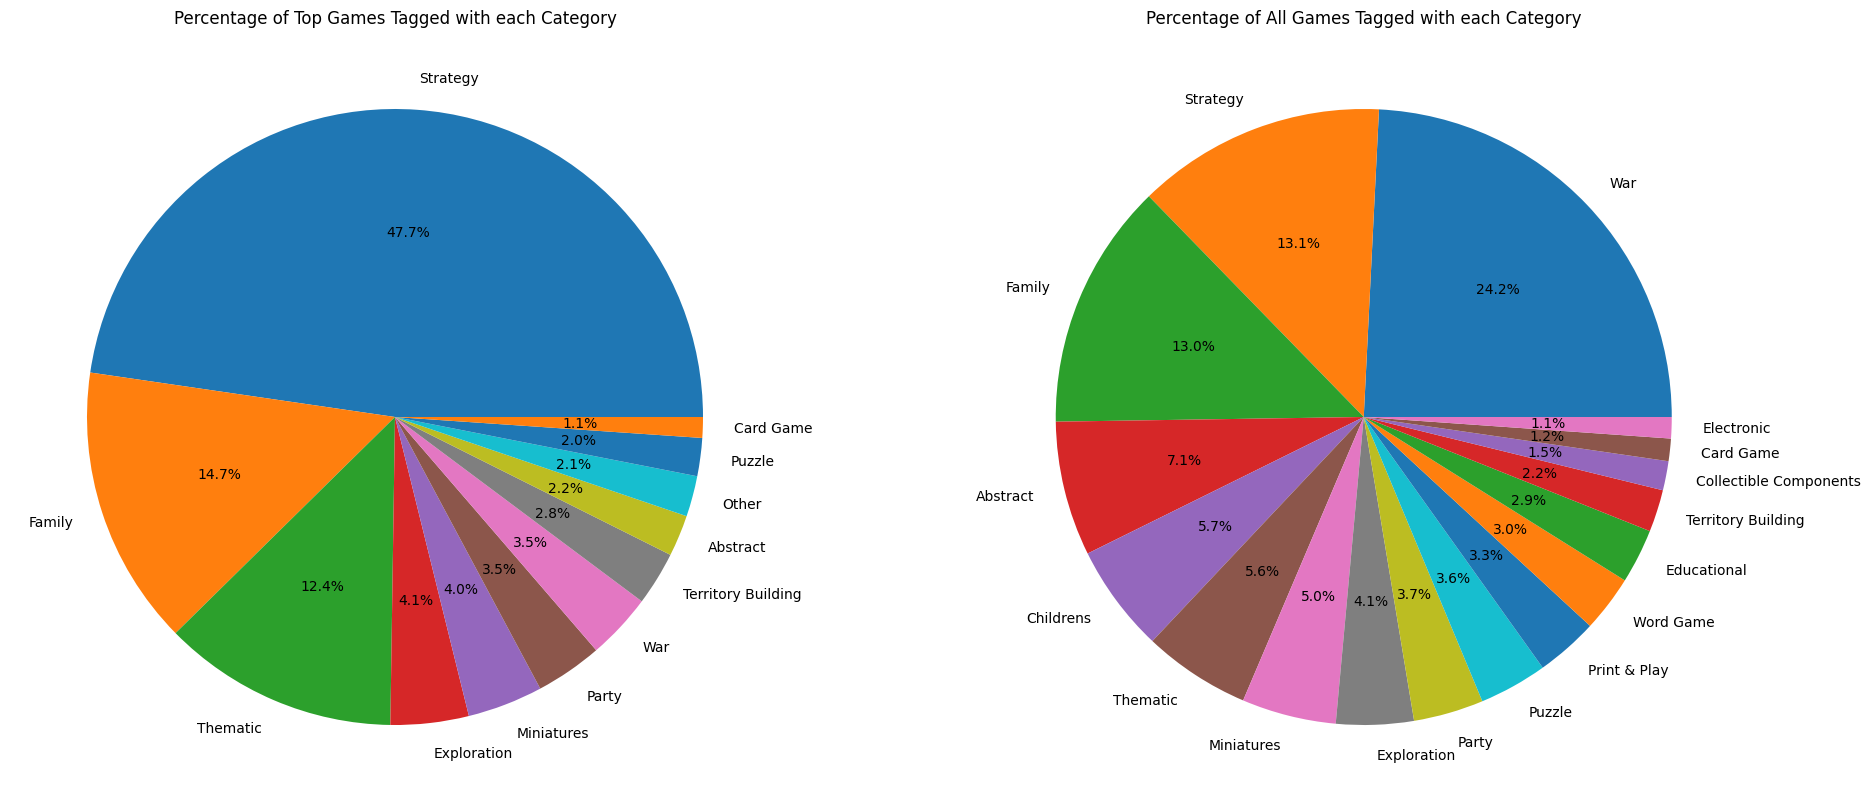

In [69]:
#@title Code
display_category_charts(500)

## Theme Statistics

The top rank threshold is used to define the range of games considered the most succesful, beginning from rank 1. The suggested value is for the top 500 games. 

The number of themes to display will give you the most poular themes up to that number.

Upon submission, statistics will appear for game themes.

Top Rank Threshold (default 500):


IntText(value=500)

Number of themes to display (default 10):


IntText(value=10)

Button(description='Submit', style=ButtonStyle())

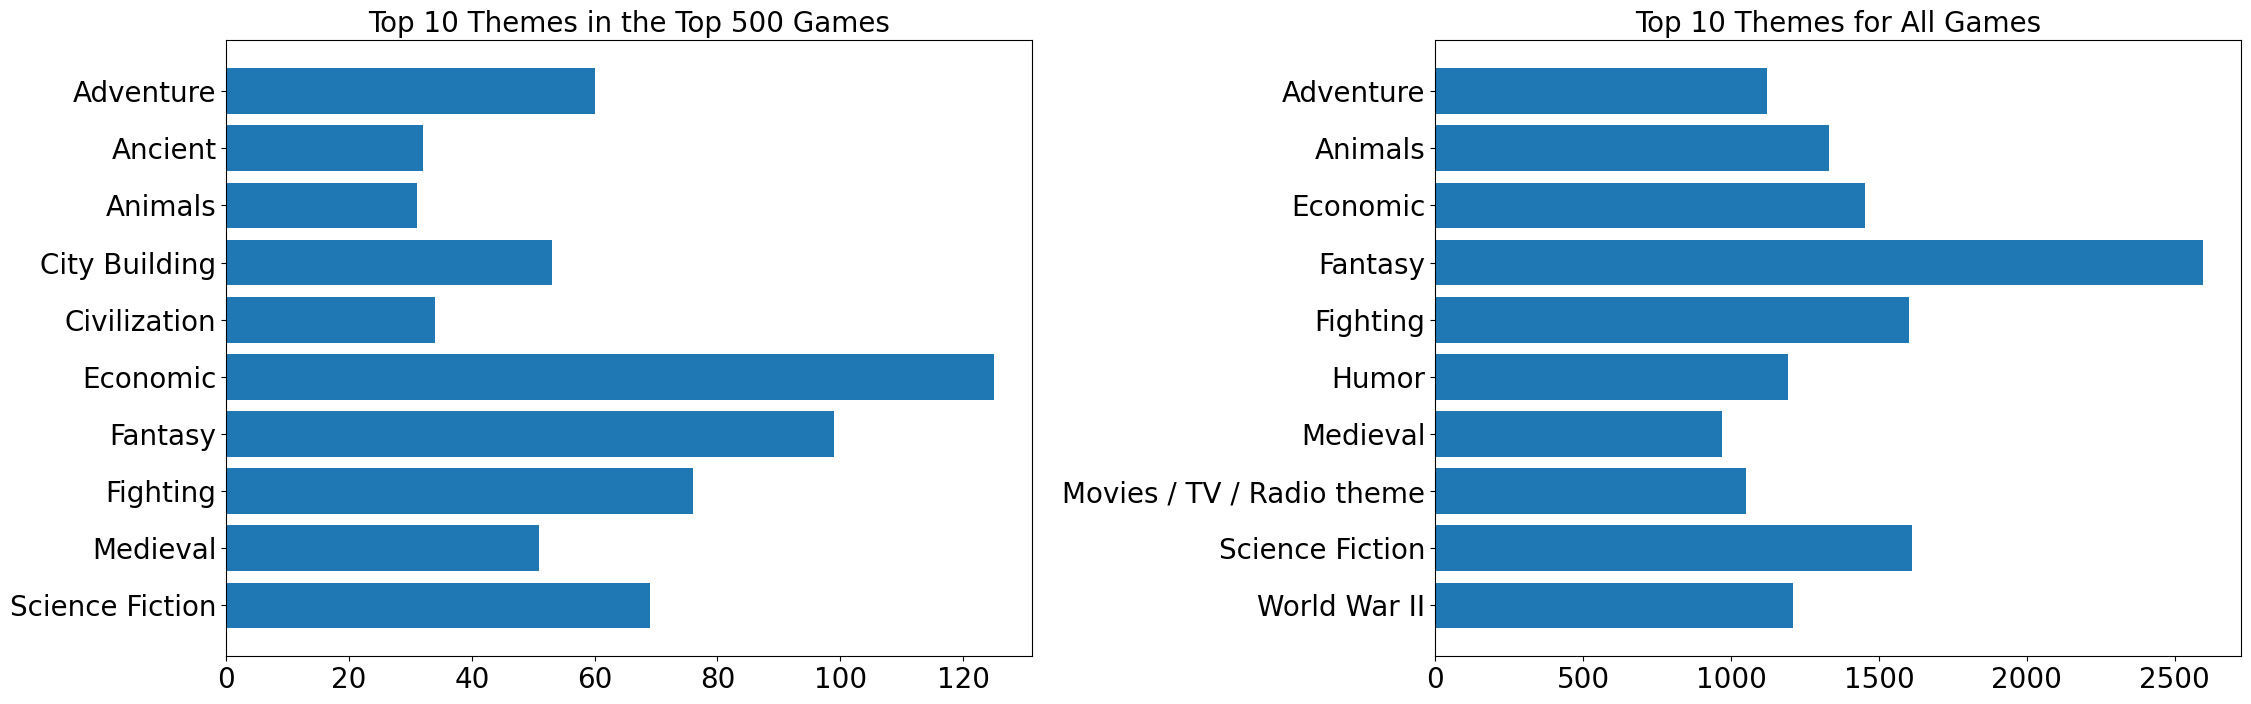

In [70]:
#@title Code
display_theme_charts(500, 10)

## Mechanic Statistics

Top Rank Threshold (default 500):


IntText(value=500)

Number of mechanics to display (default 20):


IntText(value=20)

Button(description='Submit', style=ButtonStyle())

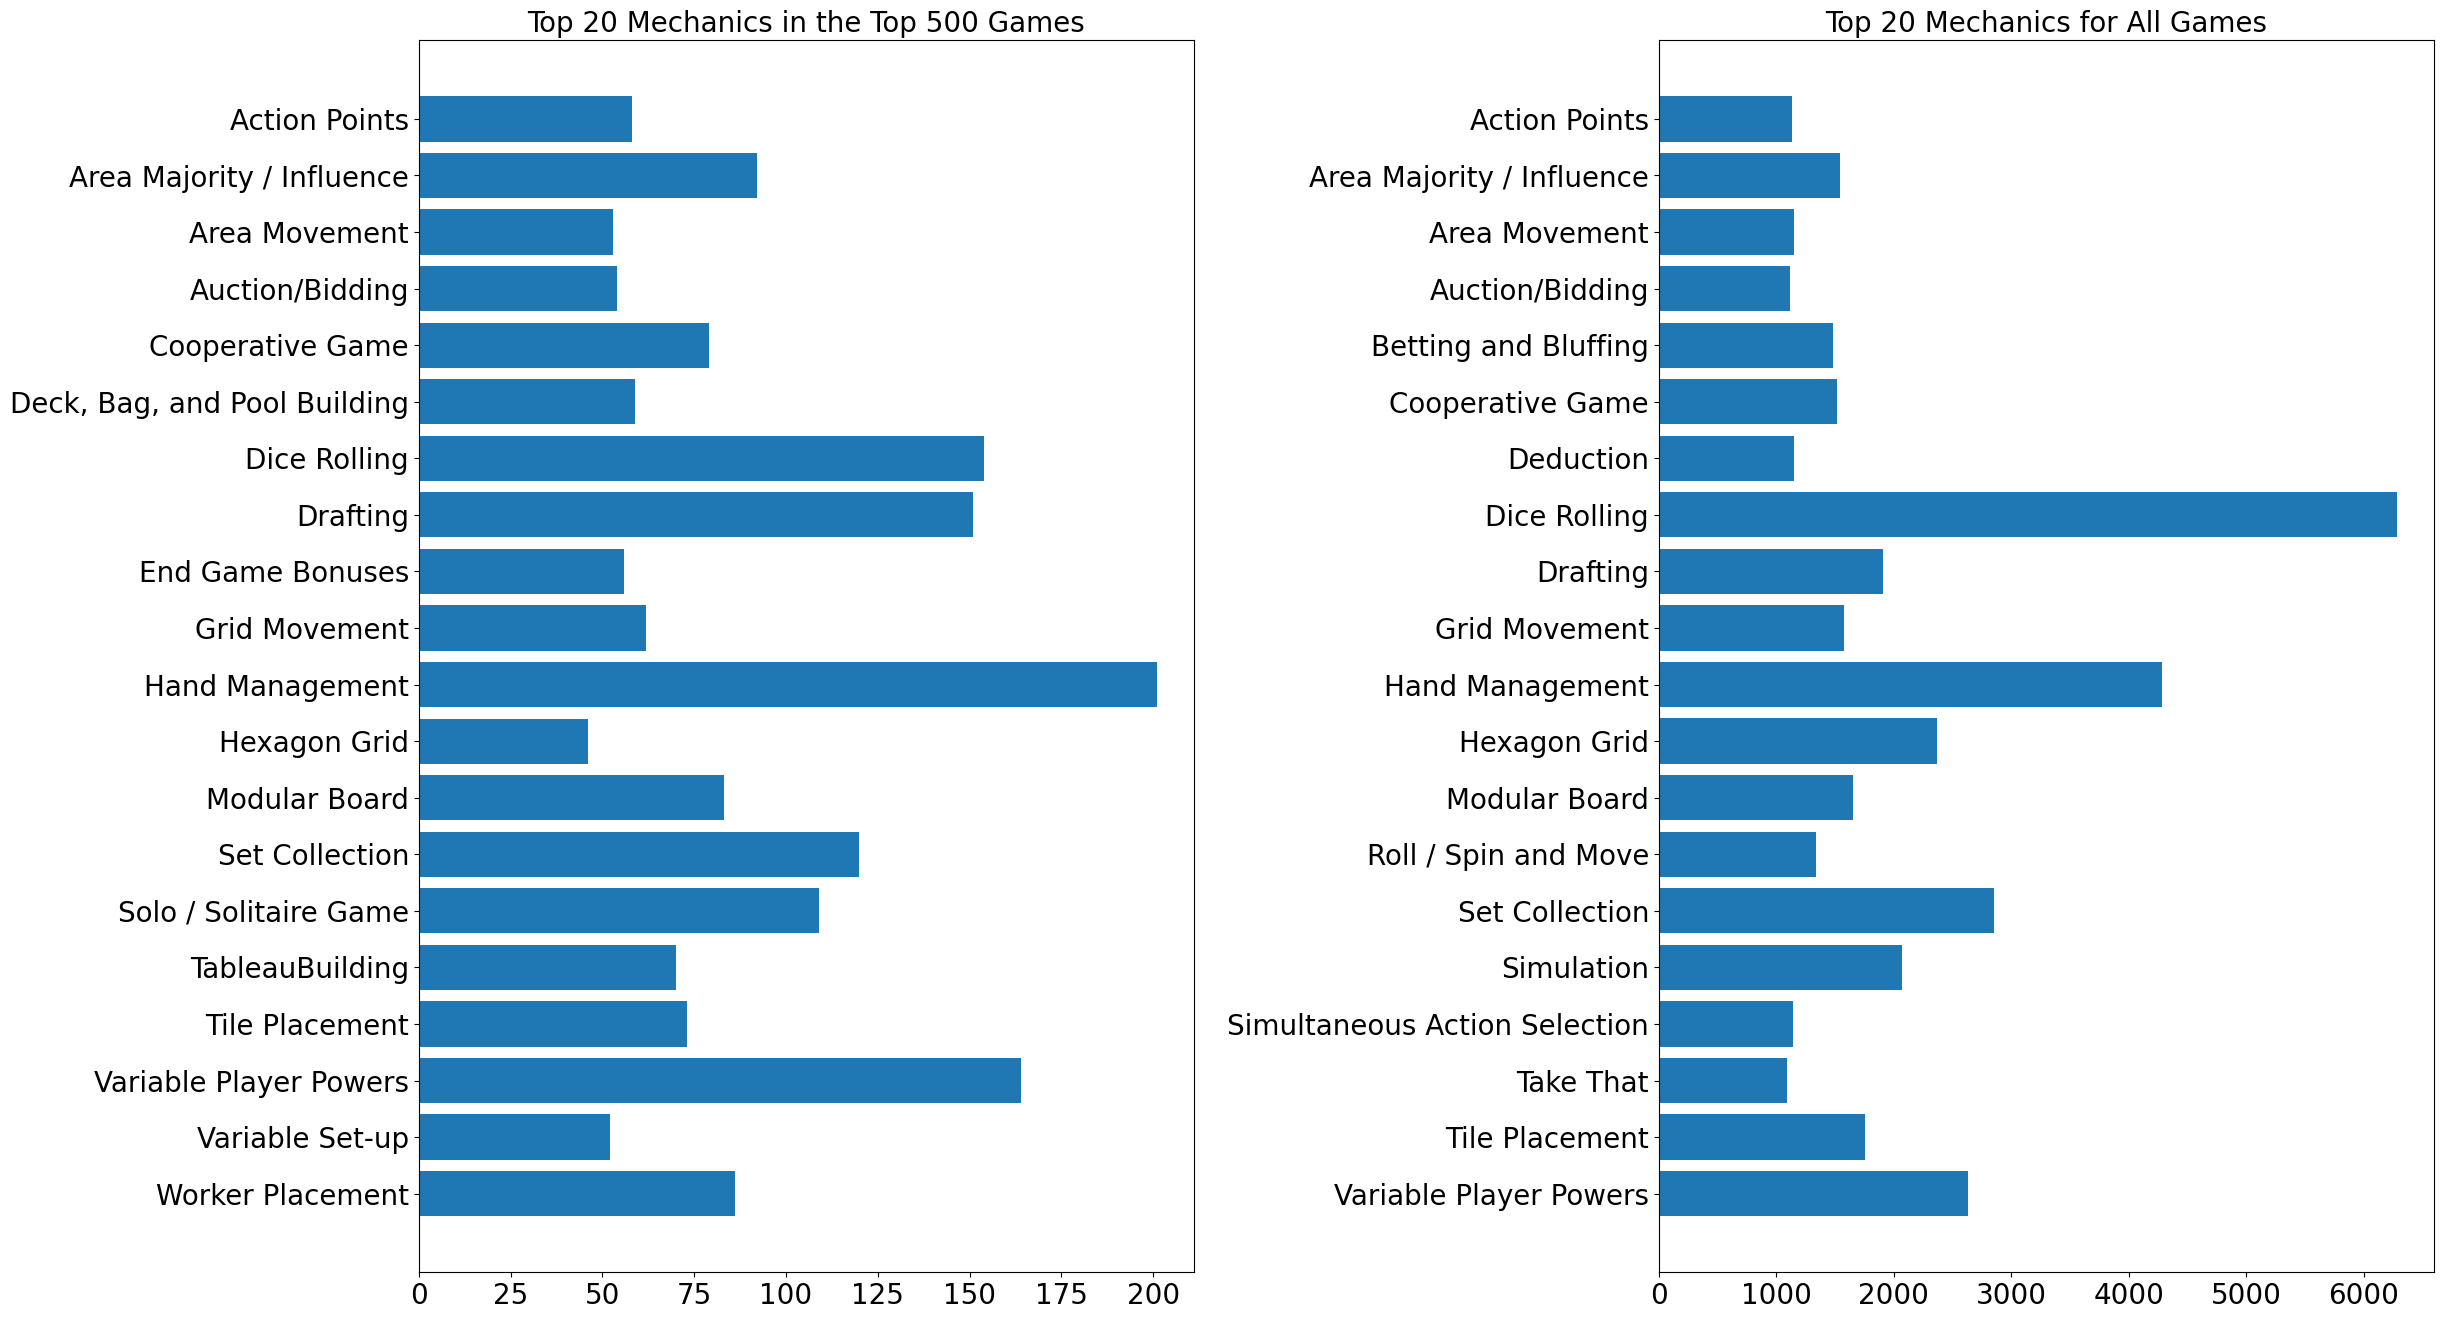

In [71]:
#@title Code
display_mechanics_charts(500, 20)

# Section 2
This tool provides board game statistics related to a list of games filtered by their categories, themes, mechanics, and other attributes. It can be used to predict the popularity rating and complexity rating for a hypothetical game.

It will also provide standard deviation charts for the ranking and rating of similar games, a bar chart of the most common mechanics associated with the selected categories, themes, and mechanics


determine the standard deviation for ranking games belonging to the filtered game type, mechanics related to the filtered game type, and predicting how a game of this type might rate and rank.

## Select Categories, Themes, and Mechanics
Combinations of categories, themes, and mechanics may be selected. Fields may be left blank. The most common fields are provided. The more fields selected, the more accurate the results.

In [72]:
#@title Code
display(clear_CTM_button)
display_CTM_options()

Button(description='Clear Selections', style=ButtonStyle())

Choose up to 3 categories:


Dropdown(options=('No Selection', 'Abstract (1087)', 'Card Game (301)', 'Childrens (874)', 'Collectible Compon…

Dropdown(options=('No Selection', 'Abstract (1087)', 'Card Game (301)', 'Childrens (874)', 'Collectible Compon…

Dropdown(options=('No Selection', 'Abstract (1087)', 'Card Game (301)', 'Childrens (874)', 'Collectible Compon…

The 5 most common categories are:
('War', 3481)
('Family', 2262)
('Strategy', 2256)
('Thematic', 1196)
('Abstract', 1087)

Choose up to 5 themes:


Dropdown(options=('No Selection', 'Adventure (1122)', 'African Americans (4)', 'Age of Reason (165)', 'Airship…

Dropdown(options=('No Selection', 'Adventure (1122)', 'African Americans (4)', 'Age of Reason (165)', 'Airship…

Dropdown(options=('No Selection', 'Adventure (1122)', 'African Americans (4)', 'Age of Reason (165)', 'Airship…

Dropdown(options=('No Selection', 'Adventure (1122)', 'African Americans (4)', 'Age of Reason (165)', 'Airship…

Dropdown(options=('No Selection', 'Adventure (1122)', 'African Americans (4)', 'Age of Reason (165)', 'Airship…

The 5 most common themes are:
('Fantasy', 2595)
('Science Fiction', 1612)
('Fighting', 1603)
('Economic', 1454)
('Animals', 1332)

Choose up to 10 mechanics:


Dropdown(options=('No Selection', 'Action Drafting (36)', 'Action Points (1137)', 'Action Queue (404)', 'Actio…

Dropdown(options=('No Selection', 'Action Drafting (36)', 'Action Points (1137)', 'Action Queue (404)', 'Actio…

Dropdown(options=('No Selection', 'Action Drafting (36)', 'Action Points (1137)', 'Action Queue (404)', 'Actio…

Dropdown(options=('No Selection', 'Action Drafting (36)', 'Action Points (1137)', 'Action Queue (404)', 'Actio…

Dropdown(options=('No Selection', 'Action Drafting (36)', 'Action Points (1137)', 'Action Queue (404)', 'Actio…

Dropdown(options=('No Selection', 'Action Drafting (36)', 'Action Points (1137)', 'Action Queue (404)', 'Actio…

Dropdown(options=('No Selection', 'Action Drafting (36)', 'Action Points (1137)', 'Action Queue (404)', 'Actio…

Dropdown(options=('No Selection', 'Action Drafting (36)', 'Action Points (1137)', 'Action Queue (404)', 'Actio…

Dropdown(options=('No Selection', 'Action Drafting (36)', 'Action Points (1137)', 'Action Queue (404)', 'Actio…

Dropdown(options=('No Selection', 'Action Drafting (36)', 'Action Points (1137)', 'Action Queue (404)', 'Actio…

The 10 most common mechanics are:
('Dice Rolling', 6279)
('Hand Management', 4282)
('Set Collection', 2852)
('Variable Player Powers', 2627)
('Hexagon Grid', 2369)
('Simulation', 2073)
('Drafting', 1906)
('Tile Placement', 1757)
('Modular Board', 1652)
('Grid Movement', 1579)


## Select Player Count, Duration, and Complexity
Select a minimum and maximum number of players, game duration, and complexity rating (weight). Fields may be left blank. This app does not account for boardgame expansions that add additional players, game duration, and game complexity.

For number of players and duration, these are hard limits; if a minimum and maximum are chosen, games with a minimum or maximum  lower or higher than the selections will not be included in the filter. For example, selecting a minimum of 2 and maximum of 5 will not include games that have a minimum of 3 and maximum of 4.

The complexiting rating is a range and will include ratings between the lower and upper threshold. For example, a lower threshold of 2 and an upper threshold of 3 will include all games rated between those values.



In [73]:
#@title Code
display(clear_PDC_button)
display_PDC_options()

Button(description='Clear Selections', style=ButtonStyle())

Players


Dropdown(description='Lower', options=('No Selection', 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12), value='No Selec…

Dropdown(description='Upper', options=('No Selection', 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, '13+'), value='N…


Duration


Dropdown(description='Lower', options=('No Selection', 30, 60, 90, 120, 150, 180, 210, 240), value='No Selecti…

Dropdown(description='Upper', options=('No Selection', 30, 60, 90, 120, 150, 180, 210, 240, '241+'), value='No…


Complexity Rating


Dropdown(description='Lower', options=('No Selection', 0, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5), value='No Select…

Dropdown(description='Upper', options=('No Selection', 0, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5), value='No Select…

## Results

After making filter selections, click on "Submit Selections" in the next frame. 

For games that meet the attribute criteria, this will provide:

1. The filter specifications 
2. The number of actual games matching the filter criteria
3. The predicted rating for a hypothetical game
4. The predicted complexity rating for a hypothetical game

If there are actual games meeting the criteria:
1. The average and median ranking
2. The average and median rating
3. A chart for the standard rank deviation
4. A chart for the standard rating deviation
5. A chart of additional mechanics most associated with the filtered games
6. A heat map for categories, themes, and mechanics in relation to rating
7. A table of actual games meeting the filter criteria

If there are no actual games that meet the criteria, data for similar games will be used if possible:
1. A chart for the standard rank deviation 
2. A chart for the standard rating deviation
3. A chart of additional mechanics most associated with the similar games
4. A heat map for categories, themes, and mechanics in relation to rating
5. A table of games similar to the filter criteria

In [74]:
#@title Code
display(submitFilterButton)

Button(description='Submit Selections', style=ButtonStyle())